In [1]:
import json

# 读取 JSON 文件
with open("/kaggle/input/molecule-data/molecule_data.json", "r") as f:
    data = json.load(f)

# 访问数据
molecule_name = list(data.keys())[0]  # 获取分子名称
time_series_data = data[molecule_name]  # 获取时间序列数据

In [2]:
frame_0 = time_series_data["0"]

energy = frame_0["energy"]  # 获取能量
bonds = frame_0["bonds"]  # 获取键信息
static_features = frame_0["static_features"]  # 获取静态特征
coords = frame_0["coords"]  # 获取坐标
dynamic_features = frame_0["dynamic_features"]  # 获取动态特征

print(f"Energy: {energy}")
print(f"First Bond Distance: {bonds[0]['distance']}")
print(f"Static Features: {static_features[:5]}")  # 只显示前 5 个
print(f"Coords: {coords[:3]}")  # 只显示前 3 组坐标
print(f"Dynamic Features: {dynamic_features}")

Energy: -186.96887291
First Bond Distance: 0.008850089622056335
Static Features: [1422.5293853487676, 4988.917010824419, 23728.57326513786, 11730.372307593527, 2721.6726468871507]
Coords: [[0.0034929694, -0.0003917685, 0.0007334854], [-0.0094577191, 0.0553268894, 0.0548315024], [0.0259368765, -0.0004491833, 0.0002240193]]
Dynamic Features: [0, 0, 0, 0, 0, 0, 0, 0, 0]


In [3]:
import numpy as np

def ref_energy(x):
    y = 2625.5 * (x +187.008272643716)
    return y

import numpy as np

def preprocess_data_v2(molecule_data):
    """
    预处理输入数据
    输入:
        molecule_data: 单个时间步的分子数据
    输出:
        X_t: (当前分子键距, 当前分子能量)
        State: (静态特征, 动态特征)
        Y_t: (下一时刻分子键距, 下一时刻分子能量)
    """
    static_features = np.array(molecule_data["static_features"])  # 静态特征（状态）
    dynamic_features = np.array(molecule_data["dynamic_features"])  # 动态特征（状态）
    bond_distances = np.array([bond["distance"] for bond in molecule_data["bonds"]])  # 键距（输入）
    energy = np.array([ref_energy(molecule_data["energy"])])  # 能量（输入）

    # 组合输入特征 X_t
    X_t = np.concatenate([bond_distances, energy])  # 输入只包含当前的键距和能量
    State = np.concatenate([static_features, dynamic_features])  # 状态包含静态和动态特征

    return X_t, State

In [4]:
# X_seq = []
# Y_seq = []

# for t in range(1, len(time_series_data) - 1):  # 遍历时间序列
#     X_t, Y_t = preprocess_data(time_series_data[f"{t}"])
#     X_seq.append(X_t)
#     Y_seq.append(Y_t)

# X_seq = np.array(X_seq)  # (T, D) 形状的输入
# Y_seq = np.array(Y_seq)  # (T, M) 形状的目标变量

# print(X_seq.shape, Y_seq.shape)
X_seq = []
State_seq = []
Y_seq = []

for t in range(1, len(time_series_data) - 1):  # 遍历时间序列
    X_t, State_t = preprocess_data_v2(time_series_data[f"{t}"])
    X_seq.append(X_t)
    State_seq.append(State_t)

    # 目标变量 Y_t 是下一时刻的键距和能量
    Y_t, _ = preprocess_data_v2(time_series_data[f"{t+1}"])
    Y_seq.append(Y_t)

X_seq = np.array(X_seq)  # (T, D) 形状的输入
State_seq = np.array(State_seq)  # (T, S) 形状的状态
Y_seq = np.array(Y_seq)  # (T, M) 形状的目标变量

print(f"X_seq shape: {X_seq.shape}, State_seq shape: {State_seq.shape}, Y_seq shape: {Y_seq.shape}")

X_seq shape: (349, 10), State_seq shape: (349, 35), Y_seq shape: (349, 10)


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

# class SSMModel(nn.Module):
#     def __init__(self, state_dim, input_dim, output_dim):
#         super(SSMModel, self).__init__()
#         self.state_dim = state_dim

#         # 状态转移矩阵 A
#         self.A = nn.Parameter(torch.randn(state_dim, state_dim) * 0.01)
#         # 输入到状态的映射 B
#         self.B = nn.Parameter(torch.randn(state_dim, input_dim) * 0.01)
#         # 状态到输出的映射 C
#         self.C = nn.Parameter(torch.randn(output_dim, state_dim) * 0.01)
#         # 输入到输出的直接映射 D
#         self.D = nn.Parameter(torch.randn(output_dim, input_dim) * 0.01)

#     def forward(self, X):
#         """
#         X: 输入时间序列 (T, D)
#         返回: 预测的 Y (T, M)
#         """
#         T, D = X.shape
#         state = torch.zeros(self.state_dim)  # 初始状态 (N,)
#         Y_pred = []

#         for t in range(T):
#             state = torch.matmul(self.A, state) + torch.matmul(self.B, X[t])  # 状态更新
#             Y_t = torch.matmul(self.C, state) + torch.matmul(self.D, X[t])  # 输出预测
#             Y_pred.append(Y_t)

#         return torch.stack(Y_pred)  # (T, M)


# class SSMModel(nn.Module):
#     def __init__(self, state_dim, input_dim, output_dim, state_input_dim):
#         """
#         state_dim: 状态维度 (N)
#         input_dim: 输入特征维度 (D) - 键距和能量
#         output_dim: 输出特征维度 (M) - 预测的键距和能量
#         state_input_dim: 状态特征维度 (S) - 静态特征和动态特征
#         """
#         super(SSMModel, self).__init__()
#         self.state_dim = state_dim

#         # 状态转移矩阵 A
#         self.A = nn.Parameter(torch.randn(state_dim, state_dim) * 0.01)
#         # 输入到状态的映射 B
#         self.B = nn.Parameter(torch.randn(state_dim, input_dim) * 0.01)
#         # 状态特征到状态更新的映射 W_state
#         self.W_state = nn.Parameter(torch.randn(state_dim, state_input_dim) * 0.01)

#         # 状态到输出的映射 C
#         self.C = nn.Parameter(torch.randn(output_dim, state_dim) * 0.01)
#         # 输入到输出的直接映射 D
#         self.D = nn.Parameter(torch.randn(output_dim, input_dim) * 0.01)
#         # 状态特征到最终输出的映射 E
#         self.E = nn.Parameter(torch.randn(output_dim, state_input_dim) * 0.01)

#     def forward(self, X, State):
#         """
#         X: 输入时间序列 (T, D) - 当前分子的键距和能量
#         State: 变化的状态 (T, S) - 静态和动态特征
#         返回: 预测的 Y (T, M) - 下一时刻的键距和能量
#         """
#         T, D = X.shape
#         _, S = State.shape

#         state = torch.zeros(self.state_dim)  # 初始状态 (N,)
#         Y_pred = []

#         for t in range(T):
#             # 状态更新
#             state = torch.matmul(self.A, state) + torch.matmul(self.B, X[t]) + torch.matmul(self.W_state, State[t])
            
#             # 输出计算
#             Y_t = torch.matmul(self.C, state) + torch.matmul(self.D, X[t]) + torch.matmul(self.E, State[t])
#             Y_pred.append(Y_t)

#         return torch.stack(Y_pred)  # (T, M)


class SSMModel(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim, state_input_dim):
        super(SSMModel, self).__init__()
        self.state_dim = state_dim

        # 状态转移矩阵 A
        self.A = nn.Parameter(torch.randn(state_dim, state_dim) * 0.01)
        # 输入到状态的映射 B（仅键距部分）
        self.B = nn.Parameter(torch.randn(state_dim, input_dim - 1) * 0.01)
        # 状态特征到状态更新的映射 W_state
        self.W_state = nn.Parameter(torch.randn(state_dim, state_input_dim) * 0.01)

        # 键距预测部分
        self.C = nn.Parameter(torch.randn(output_dim - 1, state_dim) * 0.01)
        self.D = nn.Parameter(torch.randn(output_dim - 1, input_dim - 1) * 0.01)
        self.E = nn.Parameter(torch.randn(output_dim - 1, state_input_dim) * 0.01)

        # **改进能量预测：增加 MLP**
        self.energy_predictor = nn.Sequential(
            nn.Linear(state_dim + state_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, X, State):
        T, D = X.shape
        _, S = State.shape

        state = torch.zeros(self.state_dim)  # 初始状态
        Y_pred = []

        for t in range(T):
            X_dist = X[t, :-1]  # 键距部分
            X_energy = X[t, -1].unsqueeze(0)  # 能量部分 (1,)

            # 状态更新
            state = torch.matmul(self.A, state) + torch.matmul(self.B, X_dist) + torch.matmul(self.W_state, State[t])

            # 预测键距
            Y_dist_t = torch.matmul(self.C, state) + torch.matmul(self.D, X_dist) + torch.matmul(self.E, State[t])
            
            # Y_dist_t = 20 * torch.sigmoid(Y_dist_t)

            # **改进能量预测：使用 MLP**
            energy_input = torch.cat([state, State[t]], dim=0)  # 组合 state + State
            Y_energy_t = self.energy_predictor(energy_input)

            # 拼接键距和能量
            Y_t = torch.cat([Y_dist_t, Y_energy_t], dim=0)
            Y_pred.append(Y_t)

        return torch.stack(Y_pred)  # (T, M)

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# ==================== 1. 数据归一化 ==================== 
X_scaler = MinMaxScaler(feature_range=(0, 1))
State_scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaler = MinMaxScaler(feature_range=(0, 1))

X_seq_norm = X_scaler.fit_transform(X_seq)  # 归一化 X_seq
State_seq_norm = State_scaler.fit_transform(State_seq)  # 归一化 State_seq
Y_seq_norm = Y_scaler.fit_transform(Y_seq)  # 归一化 Y_seq

print(f"X_seq 归一化后形状: {X_seq_norm.shape}")
print(f"State_seq 归一化后形状: {State_seq_norm.shape}")
print(f"Y_seq 归一化后形状: {Y_seq_norm.shape}")

# 转换为 PyTorch Tensor
X_tensor = torch.tensor(X_seq_norm, dtype=torch.float32)
State_tensor = torch.tensor(State_seq_norm, dtype=torch.float32)
Y_tensor = torch.tensor(Y_seq_norm, dtype=torch.float32)

# ==================== 2. 配置模型参数 ==================== 
state_dim = 64  # 隐状态维度 N
input_dim = X_tensor.shape[1]  # 输入维度 D
output_dim = Y_tensor.shape[1]  # 输出维度 M
state_input_dim = State_tensor.shape[1]  # 状态特征维度 S

# 初始化 SSM 模型
ssm_model = SSMModel(state_dim, input_dim, output_dim, state_input_dim)

# 选择优化器和损失函数
optimizer = optim.AdamW(ssm_model.parameters(), lr=0.002, weight_decay=1e-4)
loss_fn1 = nn.SmoothL1Loss(beta=0.01)  # 适用于小范围数值
# loss_fn2 = nn.MSELoss()  # 适用于能量预测

# ==================== 3. 训练循环 ==================== 
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # 前向传播
    Y_pred = ssm_model(X_tensor, State_tensor)

    # 分离距离 (键距) 和 能量
    Y_pred_distance = Y_pred[:, :-1]  # 键距预测 (T, M-1)
    Y_pred_energy = Y_pred[:, -1]  # 能量预测 (T,)

    Y_true_distance = Y_tensor[:, :-1]  # 真实键距 (T, M-1)
    Y_true_energy = Y_tensor[:, -1]  # 真实能量 (T,)

    # 计算损失
    loss_distance = loss_fn1(Y_pred_distance, Y_true_distance)  # 键距损失
    loss_energy = loss_fn1(Y_pred_energy, Y_true_energy)  # 能量损失

    # 组合总损失
    loss = loss_distance + loss_energy  # 默认等权重
    # 如果能量的数值范围比键距大，可以加权
    # energy_weight = 0.1
    # loss = loss_distance + energy_weight * loss_energy

    # 反向传播
    loss.backward()
    optimizer.step()

    # 每 10 轮打印一次损失
    if epoch % 10 == 0:
        print(f"Epoch {epoch},\t Total Loss: {loss.item():.04f},"
              f"\t Distance Loss: {loss_distance.item():.04f},\t Energy Loss: {loss_energy.item():.04f}")

# ==================== 4. 预测并反归一化 ==================== 
Y_pred_norm = ssm_model(X_tensor, State_tensor).detach().numpy()  # 预测并转换为 numpy 数组

# 反归一化 Y_pred_norm，恢复到原始尺度
Y_pred_original = Y_scaler.inverse_transform(Y_pred_norm)

print(f"\n预测值 (反归一化后):\n{Y_pred_original[:5]}")

X_seq 归一化后形状: (349, 10)
State_seq 归一化后形状: (349, 35)
Y_seq 归一化后形状: (349, 10)
Epoch 0,	 Total Loss: 0.8176,	 Distance Loss: 0.4493,	 Energy Loss: 0.3683
Epoch 10,	 Total Loss: 0.3272,	 Distance Loss: 0.1895,	 Energy Loss: 0.1377
Epoch 20,	 Total Loss: 0.2823,	 Distance Loss: 0.1558,	 Energy Loss: 0.1265
Epoch 30,	 Total Loss: 0.2449,	 Distance Loss: 0.1359,	 Energy Loss: 0.1090
Epoch 40,	 Total Loss: 0.2108,	 Distance Loss: 0.1189,	 Energy Loss: 0.0919
Epoch 50,	 Total Loss: 0.1774,	 Distance Loss: 0.1045,	 Energy Loss: 0.0729
Epoch 60,	 Total Loss: 0.1445,	 Distance Loss: 0.0907,	 Energy Loss: 0.0537
Epoch 70,	 Total Loss: 0.1229,	 Distance Loss: 0.0801,	 Energy Loss: 0.0427
Epoch 80,	 Total Loss: 0.1115,	 Distance Loss: 0.0732,	 Energy Loss: 0.0383
Epoch 90,	 Total Loss: 0.0983,	 Distance Loss: 0.0677,	 Energy Loss: 0.0307
Epoch 100,	 Total Loss: 0.0882,	 Distance Loss: 0.0630,	 Energy Loss: 0.0252
Epoch 110,	 Total Loss: 0.0794,	 Distance Loss: 0.0589,	 Energy Loss: 0.0205
Epoch 120,	

In [41]:
import numpy as np
import pandas as pd
import torch

# ==================== 1. 选择当前时刻的输入数据 ==================== 
t = 40  # 当前时刻索引

# 归一化 X_t 和 Y_t（因为模型是在归一化数据上训练的）
X_t_norm = X_scaler.transform(X_seq[t].reshape(1, -1))  # 归一化 X_t
Y_t_norm = Y_scaler.transform(X_seq[t + 1].reshape(1, -1))  # 归一化 Y_t
State_t_norm = State_scaler.transform(State_seq[-1].reshape(1, -1))  # 归一化 State_t

# 转换为 PyTorch Tensor
X_t = torch.tensor(X_t_norm, dtype=torch.float32)  # (1, D)
Y_t = torch.tensor(Y_t_norm, dtype=torch.float32)  # (1, M)
State_t = torch.tensor(State_t_norm, dtype=torch.float32)  # (1, S)

# ==================== 2. 预测下一时刻的键距和能量 ==================== 
Y_next_pred = ssm_model(X_t, State_t)

# 转换为 NumPy 并进行反归一化
Y_next_pred_numpy = Y_next_pred.detach().numpy()
Y_next_pred_original = Y_scaler.inverse_transform(Y_next_pred_numpy)  # 反归一化

# ==================== 3. 打印输入、真实值和预测结果 ==================== 
# 反归一化 X_t 和 Y_t，恢复到原始尺度（方便对比）
X_t_original = X_scaler.inverse_transform(X_t_norm)
Y_t_original = Y_scaler.inverse_transform(Y_t_norm)

# 转换为 DataFrame
df_input = pd.DataFrame(X_t_original, columns=[f"Feature_{i}" for i in range(X_t_original.shape[1])])
df_Y = pd.DataFrame(Y_t_original, columns=[f"Feature_{i}" for i in range(Y_t_original.shape[1])])
df_output = pd.DataFrame(Y_next_pred_original, columns=[f"Output_{i}" for i in range(Y_next_pred_original.shape[1])])

print("\n=== 输入特征 (X_t) ===")
print(df_input.head(1).to_string(index=False))

print("\n=== 实际的下一时刻键距和能量 (Y_GT) ===")
print(df_Y.head(1).to_string(index=False))

print("\n=== 预测的下一时刻键距和能量 (Y_next_pred) ===")
print(df_output.head(1).to_string(index=False))


=== 输入特征 (X_t) ===
 Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  Feature_7  Feature_8  Feature_9
  0.016016   0.012967   0.023361    0.04435   0.042437   0.037256   0.029332   0.017992   0.044387 137.263565

=== 实际的下一时刻键距和能量 (Y_GT) ===
 Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  Feature_7  Feature_8  Feature_9
  0.014618   0.012016   0.023152   0.042787   0.041623   0.035126   0.026572   0.016138   0.037908 136.555284

=== 预测的下一时刻键距和能量 (Y_next_pred) ===
 Output_0  Output_1  Output_2  Output_3  Output_4  Output_5  Output_6  Output_7  Output_8   Output_9
 0.018662  0.018733  0.035373  0.048096  0.040728  0.041709  0.031442  0.016187  0.047077 136.531677


In [43]:
loss_fn_mae = nn.L1Loss()  # PyTorch 的 MAE 损失函数

# 进入评估模式，防止 BatchNorm 或 Dropout 影响结果
ssm_model.eval()

with torch.no_grad():  # 关闭梯度计算，加速推理
    Y_pred = ssm_model(X_tensor, State_tensor).detach().numpy()  # 预测并转换为 NumPy
    Y_true = Y_tensor.detach().numpy()  # 真实值转换为 NumPy

    # === 1️⃣ 反归一化 ===
    Y_pred_original = Y_scaler.inverse_transform(Y_pred)  # 反归一化预测值
    Y_true_original = Y_scaler.inverse_transform(Y_true)  # 反归一化真实值

    # === 2️⃣ 分离键距和能量 ===
    Y_pred_distance = Y_pred_original[:, :-1]  # 键距预测
    Y_pred_energy = Y_pred_original[:, -1]  # 能量预测

    Y_true_distance = Y_true_original[:, :-1]  # 真实键距
    Y_true_energy = Y_true_original[:, -1]  # 真实能量

    # === 3️⃣ 计算最终损失（在原始尺度下） ===
    final_loss_distance = np.mean(np.abs(Y_pred_distance - Y_true_distance))  # 键距 MAE
    final_loss_energy = np.mean(np.abs(Y_pred_energy - Y_true_energy))  # 能量 MAE

    # 计算总损失（可以简单相加，也可以加权）
    final_total_loss = final_loss_distance + final_loss_energy  # 默认等权重

print("\n=== 🏆 最终损失 (Final Loss, 反归一化后) ===")
print(f"Total Loss: {final_total_loss:.06f}")
print(f"Distance MAE Loss: {final_loss_distance:.06f}")
print(f"Energy MAE Loss: {final_loss_energy:.06f}")


=== 🏆 最终损失 (Final Loss, 反归一化后) ===
Total Loss: 0.381969
Distance MAE Loss: 0.002389
Energy MAE Loss: 0.379581


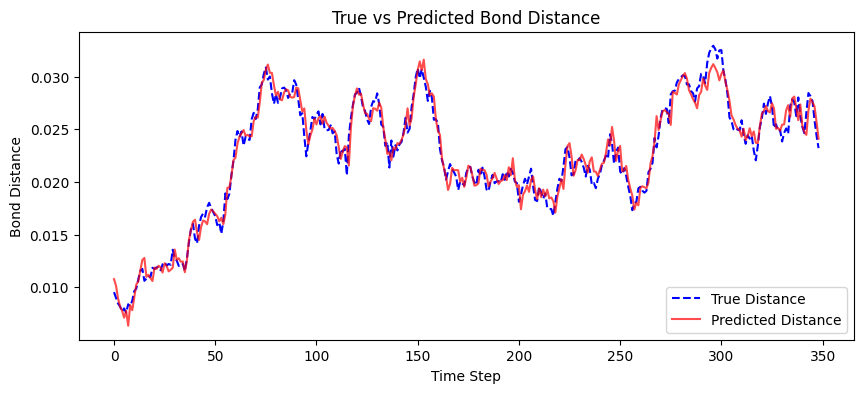

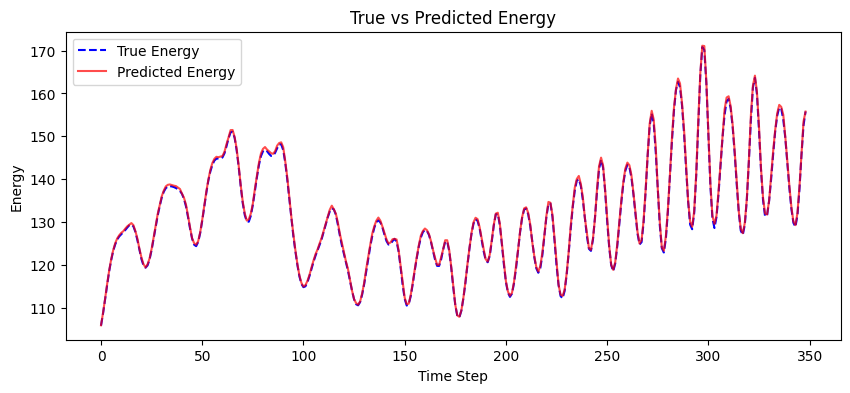

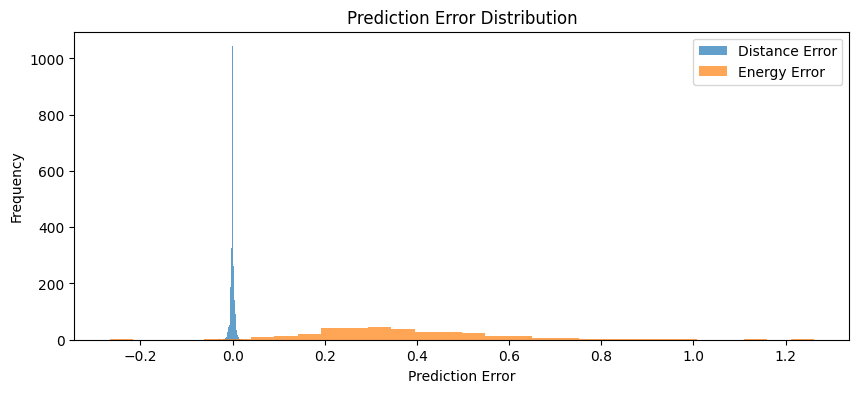

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# 进入评估模式
ssm_model.eval()

with torch.no_grad():  
    Y_pred = ssm_model(X_tensor, State_tensor).detach().numpy()  # 预测并转换为 NumPy
    Y_true = Y_tensor.detach().numpy()  # 真实值转换为 NumPy

    # === 1️⃣ 反归一化 ===
    Y_pred_original = Y_scaler.inverse_transform(Y_pred)  # 反归一化预测值
    Y_true_original = Y_scaler.inverse_transform(Y_true)  # 反归一化真实值

    # === 2️⃣ 分离键距和能量 ===
    Y_pred_distance = Y_pred_original[:, :-1]  # 预测的键距
    Y_pred_energy = Y_pred_original[:, -1]  # 预测的能量

    Y_true_distance = Y_true_original[:, :-1]  # 真实的键距
    Y_true_energy = Y_true_original[:, -1]  # 真实的能量

    # === 3️⃣ 计算误差 ===
    error_distance = Y_pred_distance - Y_true_distance  # 键距误差
    error_energy = Y_pred_energy - Y_true_energy  # 能量误差

# ======================== 1️⃣ 键距对比曲线 ========================
plt.figure(figsize=(10, 4))
plt.plot(Y_true_distance[:, 0], label="True Distance", color="blue", linestyle="dashed")
plt.plot(Y_pred_distance[:, 0], label="Predicted Distance", color="red", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Bond Distance")
plt.title("True vs Predicted Bond Distance")
plt.legend()
plt.show()

# ======================== 2️⃣ 能量对比曲线 ========================
plt.figure(figsize=(10, 4))
plt.plot(Y_true_energy, label="True Energy", color="blue", linestyle="dashed")
plt.plot(Y_pred_energy, label="Predicted Energy", color="red", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Energy")
plt.title("True vs Predicted Energy")
plt.legend()
plt.show()

# ======================== 3️⃣ 误差分布 ========================
plt.figure(figsize=(10, 4))
plt.hist(error_distance.flatten(), bins=30, alpha=0.7, label="Distance Error")
plt.hist(error_energy, bins=30, alpha=0.7, label="Energy Error")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution")
plt.legend()
plt.show()